In [1]:
%matplotlib inline
%run ../setup/nb_setup

# Orbits 2: Orbits in Axisymmetric Potentials

Author(s): Adrian Price-Whelan


## Learning goals

In this tutorial, we will introduce axisymmetric potential models, and explore differences between orbits in non-spherical potentials with what we learned about orbits in spherical systems.


## Introduction

As we saw in the previous tutorial, while spherical potential models can have complex radial density profiles, orbits in spherical potential models are planar and can be characterized by their radial and azimuthal frequencies because these orbits have at least four isolating integrals of motion (energy and the three components of angular momentum). As we will see in this tutorial, as the symmetries of a potential model are relaxed (from spherical to axisymmetric, and then in the next tutorial, from axisymmetric to triaxial), the number of isolating integrals of motion for a generic orbit decreases to three, and they become difficult to compute. The implication of this is that generic orbits in non-spherical potential models are no longer confined to a plane: They fill a three-dimensional volume instead of a two-dimensional region. In addition, these more complex models have regions of *chaotic* or irregular orbits, which differ from regular orbits in many important ways, as we will see in the next tutorial. 

In this tutorial, we will introduce some commonly-used axisymmetric gravitational potential models, compute the orbits of particles in some of these models, and analyze the properties of orbits in non-spherical models.


## Terminology and Notation

- (See Orbits tutorial 1)
- Cylindrical radius: $R = \sqrt{x^2 + y^2}$
- Maximum $z$ excursion: $z_\textrm{max} = \textrm{max}_\textrm{time}(z)$

### Notebook Setup and Package Imports

In [9]:
from astropy.constants import G
import astropy.units as u

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic

## Axisymmetric Potential Models

Rather than having spherical symmetry, axisymmetric potential models are symmetric to rotations around a particular axis. A common use case for these potential models is for representing flattened and disky systems (like the stellar and gas disks of the Milky Way). A common way of constructing axisymmetric potentials is to start with a spherical potential model, but replace the spherical radius with an elliptical radius that breaks the symmetry between $x, y$ and $z$. For example:

$$
r = \sqrt{x^2 + y^2 + z^2} \rightarrow \sqrt{x^2 + y^2 + (|z| + a)^2}
$$

By convention, in many contexts we will take the $z$ axis to be the symmetry axis, so we often use cylindrical coordinates $R, z$ when working with axisymmetric models. 

One commonly-used axisymmetric model is the Miyamoto–Nagai (MN) potential, which is given by

$$
\Phi_{\textrm{MN}}(R, z) = - \frac{G\, M}{\sqrt{R^2 + (a + \sqrt{z^2 + b^2})^2}}
$$

In the limit that $a \rightarrow 0$, the MN potential reduces to the spherical Plummer model introduced in the previous tutorial. In the limit that $b \rightarrow 0$, the MN potential reduces to the potential generated by an infinitely-thin disk. Depending on the setting of $a$ and $b$, we can represent a variety of flattened density distributions, like galactic stellar or gas disks. 

To get a feel for how orbits behave in axisymmetric potentials, we will compute some orbits in the MN potential using [Gala](http://gala.adrian.pw/). We will start by defining a model that has parameters similar to the stellar mass distribution in the local part of the Galactic disk (parameter values taken from [this paper](https://ui.adsabs.harvard.edu/abs/2021ApJ...910...17P/abstract)):

In [10]:
mn_disk = gp.MiyamotoNagaiPotential(
    m=6.98e10 * u.Msun, a=3 * u.kpc, b=0.28 * u.kpc, units=galactic
)

To start off, we will first use Gala to plot equipotential and isodensity contours to visualize the structure of this potential–density pair. To do this, we will visualize the lines of equal potential/density in 2D slices of the 3D models. We therefore need to specify which axis to "slice," and what value in that coordinate to slice at. In the other two coordinates, we need to specify grids over which to compute the potential or density (so we can use matplotlib's `contourf()` function to visualize the curves). Here, we will make plots of x-y (z=0) and x-z (y=0) slices. We will compute the potential and density on grids of 256 by 256 points between (-10, 10) kpc:

In [11]:
grid = np.linspace(-10, 10, 256) * u.kpc

We will first plot the isopotential contours using the `.plot_contours()` method on any Gala potential object:

Text(0.5, 0.98, 'Iso-potential contours')

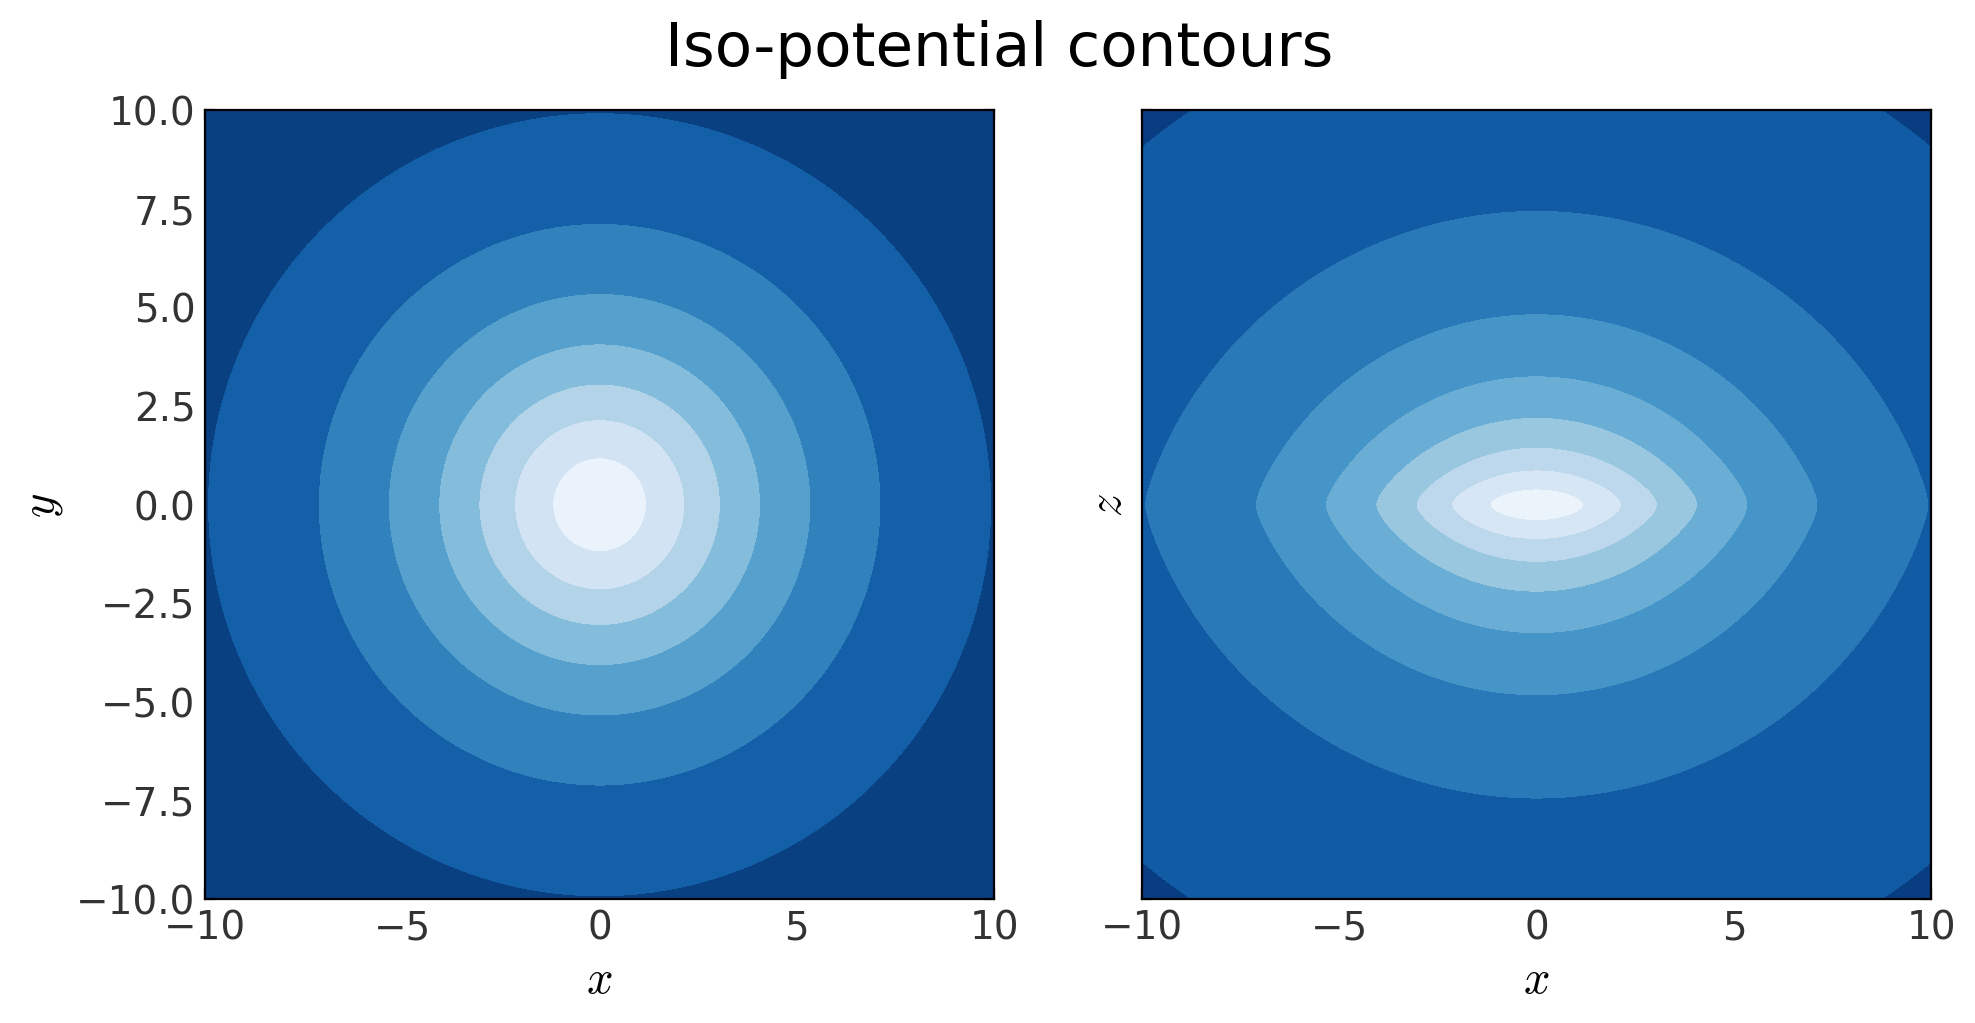

In [12]:
fig, axes = plt.subplots(
    1, 2, figsize=(10, 5), sharex=True, sharey=True, constrained_layout=True
)
mn_disk.plot_contours(grid=(grid, grid, 0), ax=axes[0])
mn_disk.plot_contours(grid=(grid, 0, grid), ax=axes[1])

for ax in axes:
    ax.set_xlabel("$x$")
axes[0].set_ylabel("$y$")
axes[1].set_ylabel("$z$")

for ax in axes:
    ax.set_aspect("equal")
fig.suptitle("Iso-potential contours", fontsize=22)

For comparison, we will now plot the same slices, but visualizing the isodensity contours using the `.plot_density_contours()` method of any Gala potential object:

Text(0.5, 0.98, 'Iso-density contours')

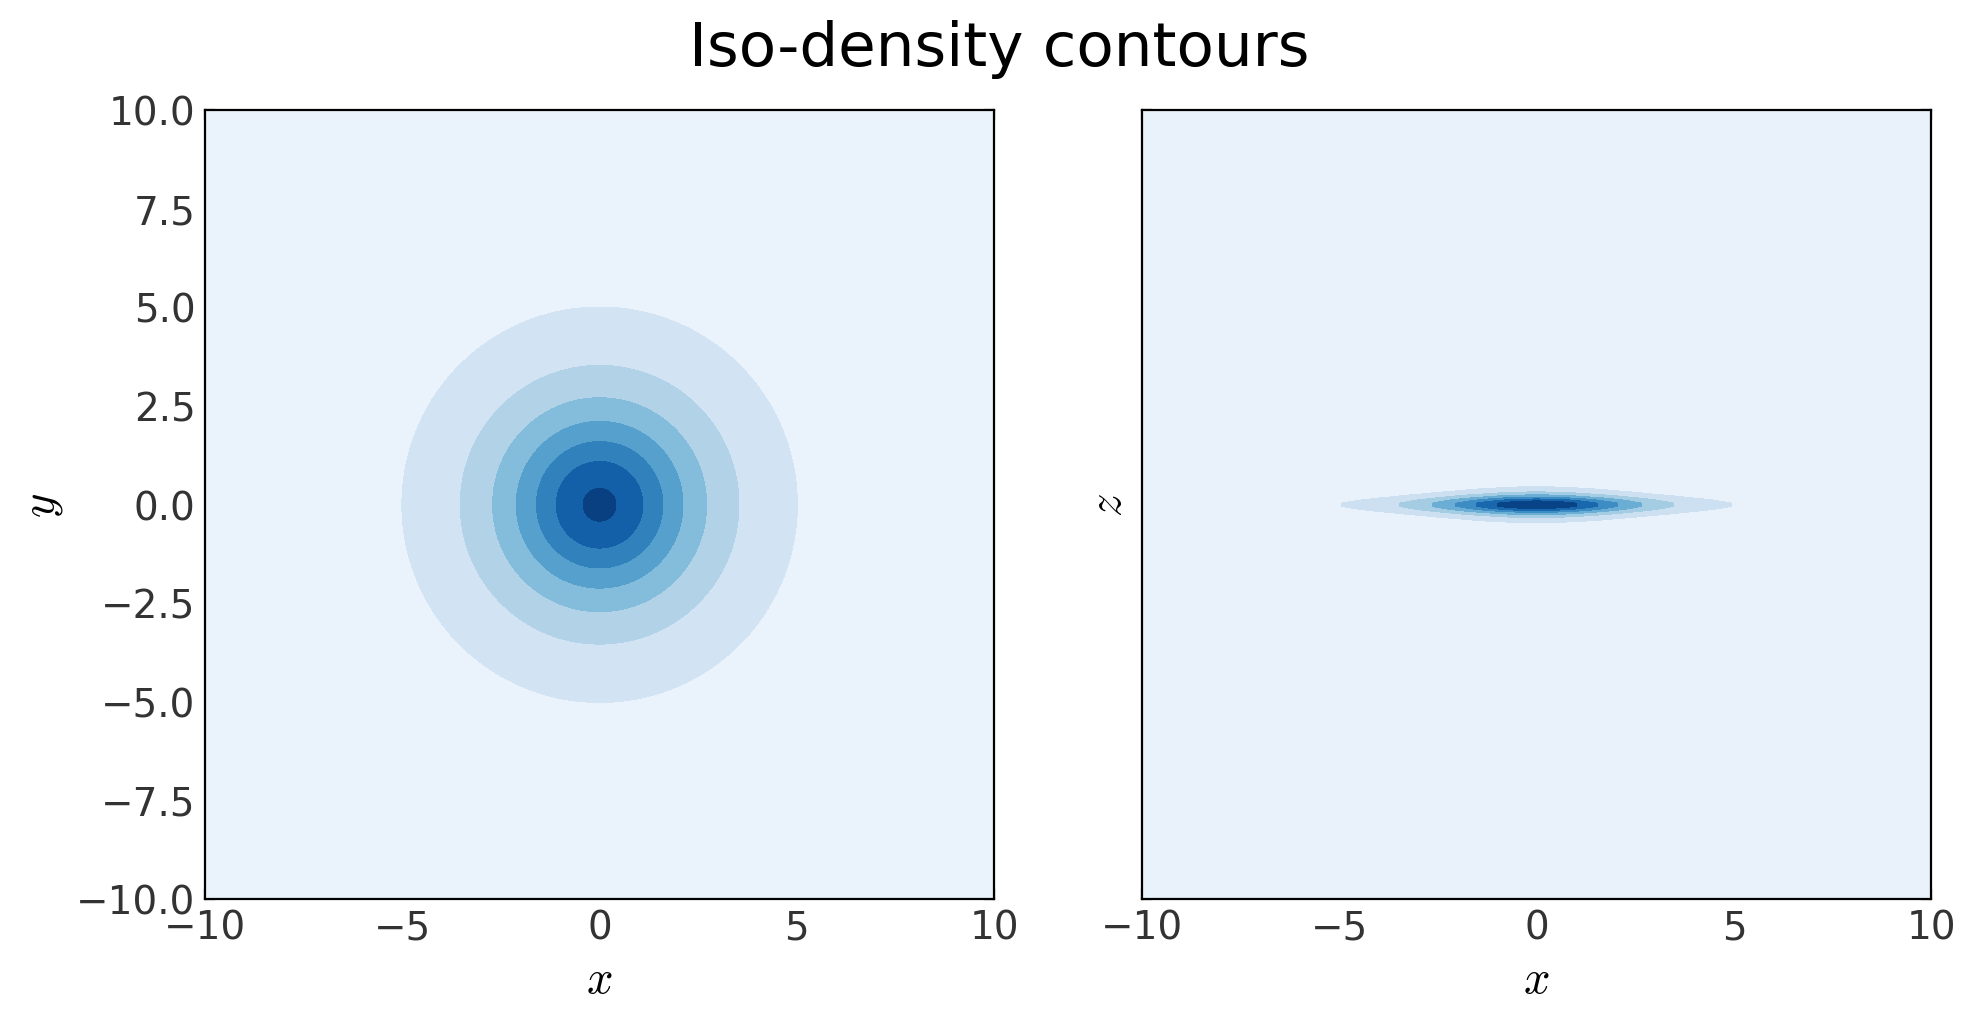

In [13]:
fig, axes = plt.subplots(
    1, 2, figsize=(10, 5), sharex=True, sharey=True, constrained_layout=True
)
mn_disk.plot_density_contours(grid=(grid, grid, 0), ax=axes[0])
mn_disk.plot_density_contours(grid=(grid, 0, grid), ax=axes[1])

for ax in axes:
    ax.set_xlabel("$x$")
axes[0].set_ylabel("$y$")
axes[1].set_ylabel("$z$")

for ax in axes:
    ax.set_aspect("equal")
fig.suptitle("Iso-density contours", fontsize=22)

Note that the density contours are *much* more "disky" than the potential contours (i.e. the axis ratio comparing $z$ to $R$ is much smaller in the density than in the potential). This is generally true: Any flattening or axis ratio in density leads to less flattening / rounder potential contours. Keep this in mind for later! Setting a very small flattening parameter in the potential can therefore lead to very strange (or unphysical) density distributions.

Below, we will compute some orbits in the MN model. However, we would like to compare these orbits to orbits computed in an equivalent spherical, Plummer model with the same mass and scale radius as our disk. We will therefore first define a plummer model with the same mass and scale radius to use below.

### Exercise: Defining an comparison Plummer model

As mentioned above, in a particular limit, the MN potential becomes the Plummer potential. What should we set the Plummer scale length to so that, in the midplane (z=0) it has the same profile as our MN potential? I.e. what combination of the MN scale parameters $a_\textrm{MN}$ and $b_\textrm{MN}$ should we set the Plummer scale length to?

Write the answer here:

ANSWER: The Miyamoto-Nagai potential becomes the Plummer potentia when a --> 0. This is because the Miyamoto-Nagai potential becomes 
$$
\Phi_{\textrm{MN}}(R, z) = - \frac{G\, M}{\sqrt{R^2 + z^2 + b^2}}
$$
This means that in the midplane (when z=0), this is the Plummer potential. Therefore, we should set $b=0.28$ kpc for the Plummer potential to be exactly the same as Miyamoto-Nagai for $a=0$

Define the comparison Plummer model using the mass from the MN potential, and the correct combination of the MN scale parameters (you can use `mn_disk.parameters['m']`, `mn_disk.parameters['a']`, and `mn_disk.parameters['b']` to retrieve the parameter values so you don't have to re-define them).

In [48]:
plummer = gp.PlummerPotential(m = 6.98e10 * u.Msun, b=3.28*u.kpc, units=galactic)
plummer

<PlummerPotential: m=6.98e+10, b=3.28 (kpc,Myr,solMass,rad)>

Demonstrate that the mass enclosed (computed assuming that both potentials are spherical) are equivalent in the midplane at $(x, y, z) = (8, 0, 0)~\textrm{kpc}$

In [51]:
mn_disk_plummer = gp.MiyamotoNagaiPotential(
    m=6.98e10 * u.Msun, a=0 * u.kpc, b=0.28 * u.kpc, units=galactic
)
Menc_MN = mn_disk.mass_enclosed(q = [8, 0, 0] * u.kpc)
Menc_plummer = plummer.mass_enclosed(q = [8, 0, 0] * u.kpc)
print(Menc_MN, Menc_plummer)

[5.52885737e+10] solMass [5.52885737e+10] solMass


---

## Orbits in axisymmetric potentials

In spherical potential models, we saw that orbits are confined to a plane, and can either be circular or have some radial oscillations that cause orbits to form a rosette pattern. 

In axisymmetric potential models, new types of orbital shapes are allowed, and circular orbits only exist in the symmetry plane (here, the $x$-$y$ plane). In particular, as we will see, generic orbits are no longer confined to a plane and instead can oscillate in the $z$ direction with a non-commensurate frequency.

Even though the concept of the circular velocity only makes sense in the symmetry plane, we can still use the value of the circular velocity (computed assuming a spherical mass enclosed) as a way of initializing orbits, because the value of $v_{\rm circ}$ will have the right order of magnitude to stay bound and remain *close* to circular in many regimes. To demonstrate the types of orbits that we see in axisymmetric potentials, we will therefore compute three orbits in both the MN and comparison Plummer potentials using the circular velocity to inform our initial conditions. In the example below, we will start one orbit in the $x,y$ plane, one started slightly above the $x,y$ plane, and a third started far above the $x,y$ plane.

In [52]:
# We first define the positions: These are [x, y, z] values
# for the three orbital initial conditions
mn_xyz = ([[8, 0, 0.0], [8, 0, 1.0], [8, 0, 10.0]] * u.kpc).T

# We compute the "circular velocity" (assuming this is a
# spherical potential) at each of the locations
mn_vcirc = mn_disk.circular_velocity(mn_xyz)
print(mn_vcirc)

# We then use the circular velocity to set the scale of our
# initial velocities: We set the vy equal to the circular velocity,
# and vx equal to 10% of the circular velocity.
# The line below uses Numpy array broadcasting:
# https://numpy.org/doc/stable/user/basics.broadcasting.html
mn_vxyz = mn_vcirc[np.newaxis] * np.array([0.1, 1, 0])[:, np.newaxis]

mn_w0 = gd.PhaseSpacePosition(pos=mn_xyz, vel=mn_vxyz)

[172.40634473 168.2805001  127.91944994] km / s


We will use these same intial conditions to compute orbits in both potential models and compare them below:

In [53]:
mn_dt = 1.0 * u.Myr
mn_steps = 4000

mn_orbits = mn_disk.integrate_orbit(mn_w0, dt=mn_dt, n_steps=mn_steps)

plummer_orbits = plummer.integrate_orbit(mn_w0, dt=mn_dt, n_steps=mn_steps)

Let's plot the 3D configurations of the orbits computed in each of the potentials: We can use the `.plot_3d()` method on any `Orbit` object to make these plots for us, and in each panel the different colors will correspond to the different initial conditions:

Text(0.5, 0.92, 'Plummer')

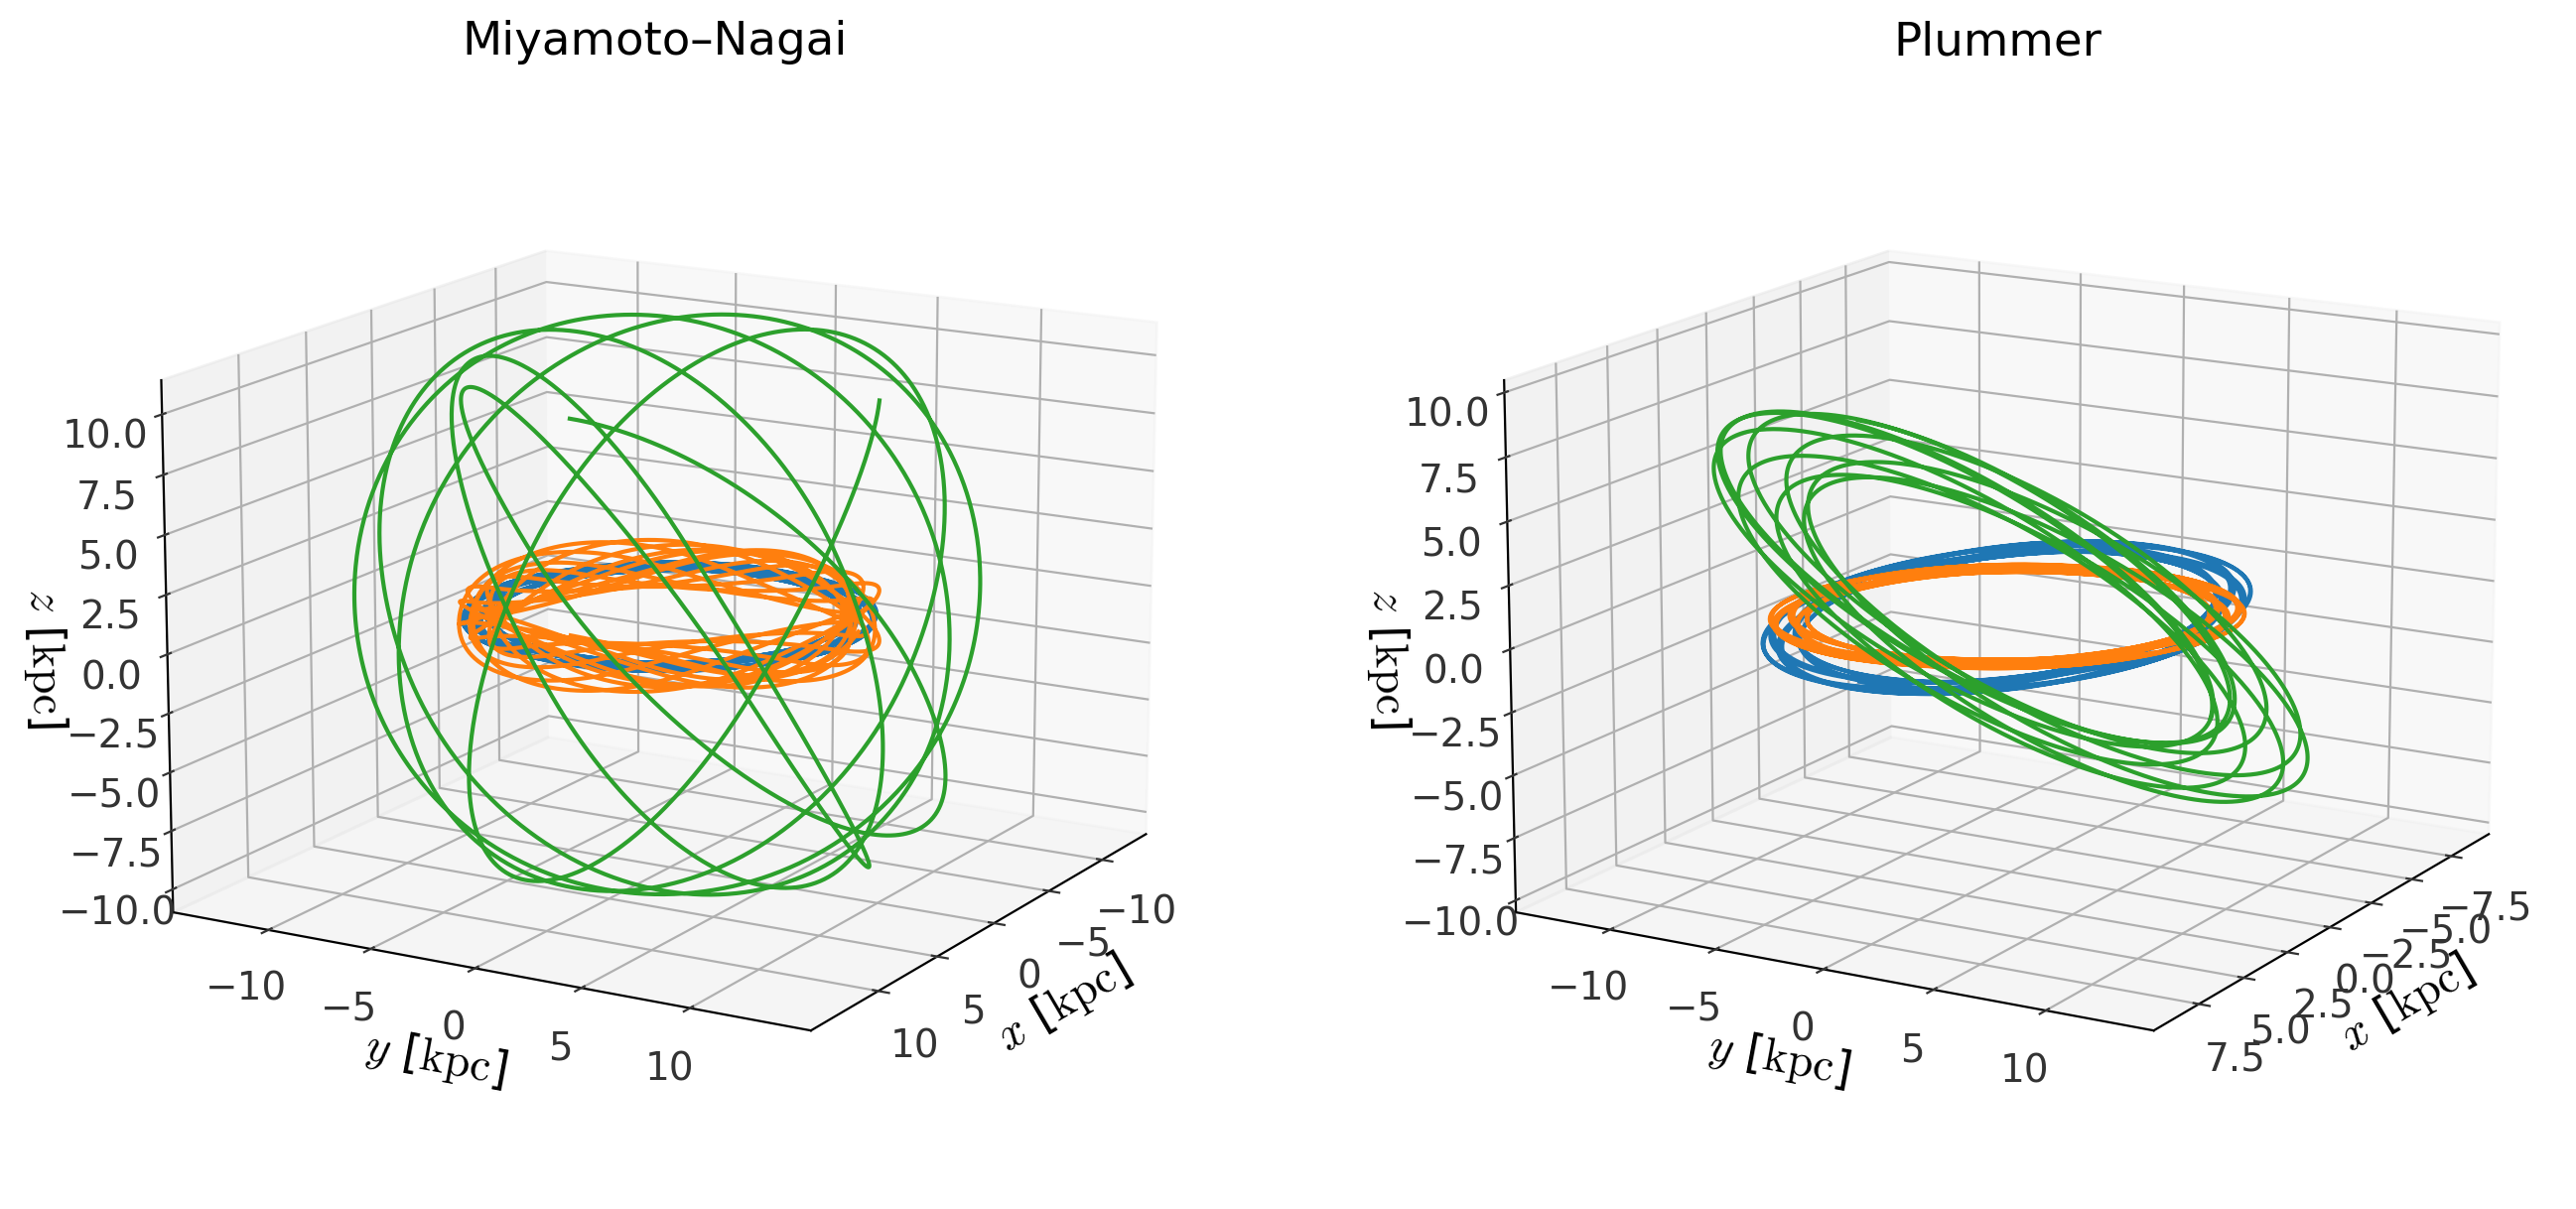

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), subplot_kw=dict(projection="3d"))

_ = mn_orbits.plot_3d(ax=axes[0])
_ = plummer_orbits.plot_3d(ax=axes[1])

for ax in axes:
    ax.azim = 30
    ax.elev = 15

axes[0].set_title("Miyamoto–Nagai")
axes[1].set_title("Plummer")

We could also instead all 2D projections of the orbits (xy, xz, yz) using the `.plot()` method:

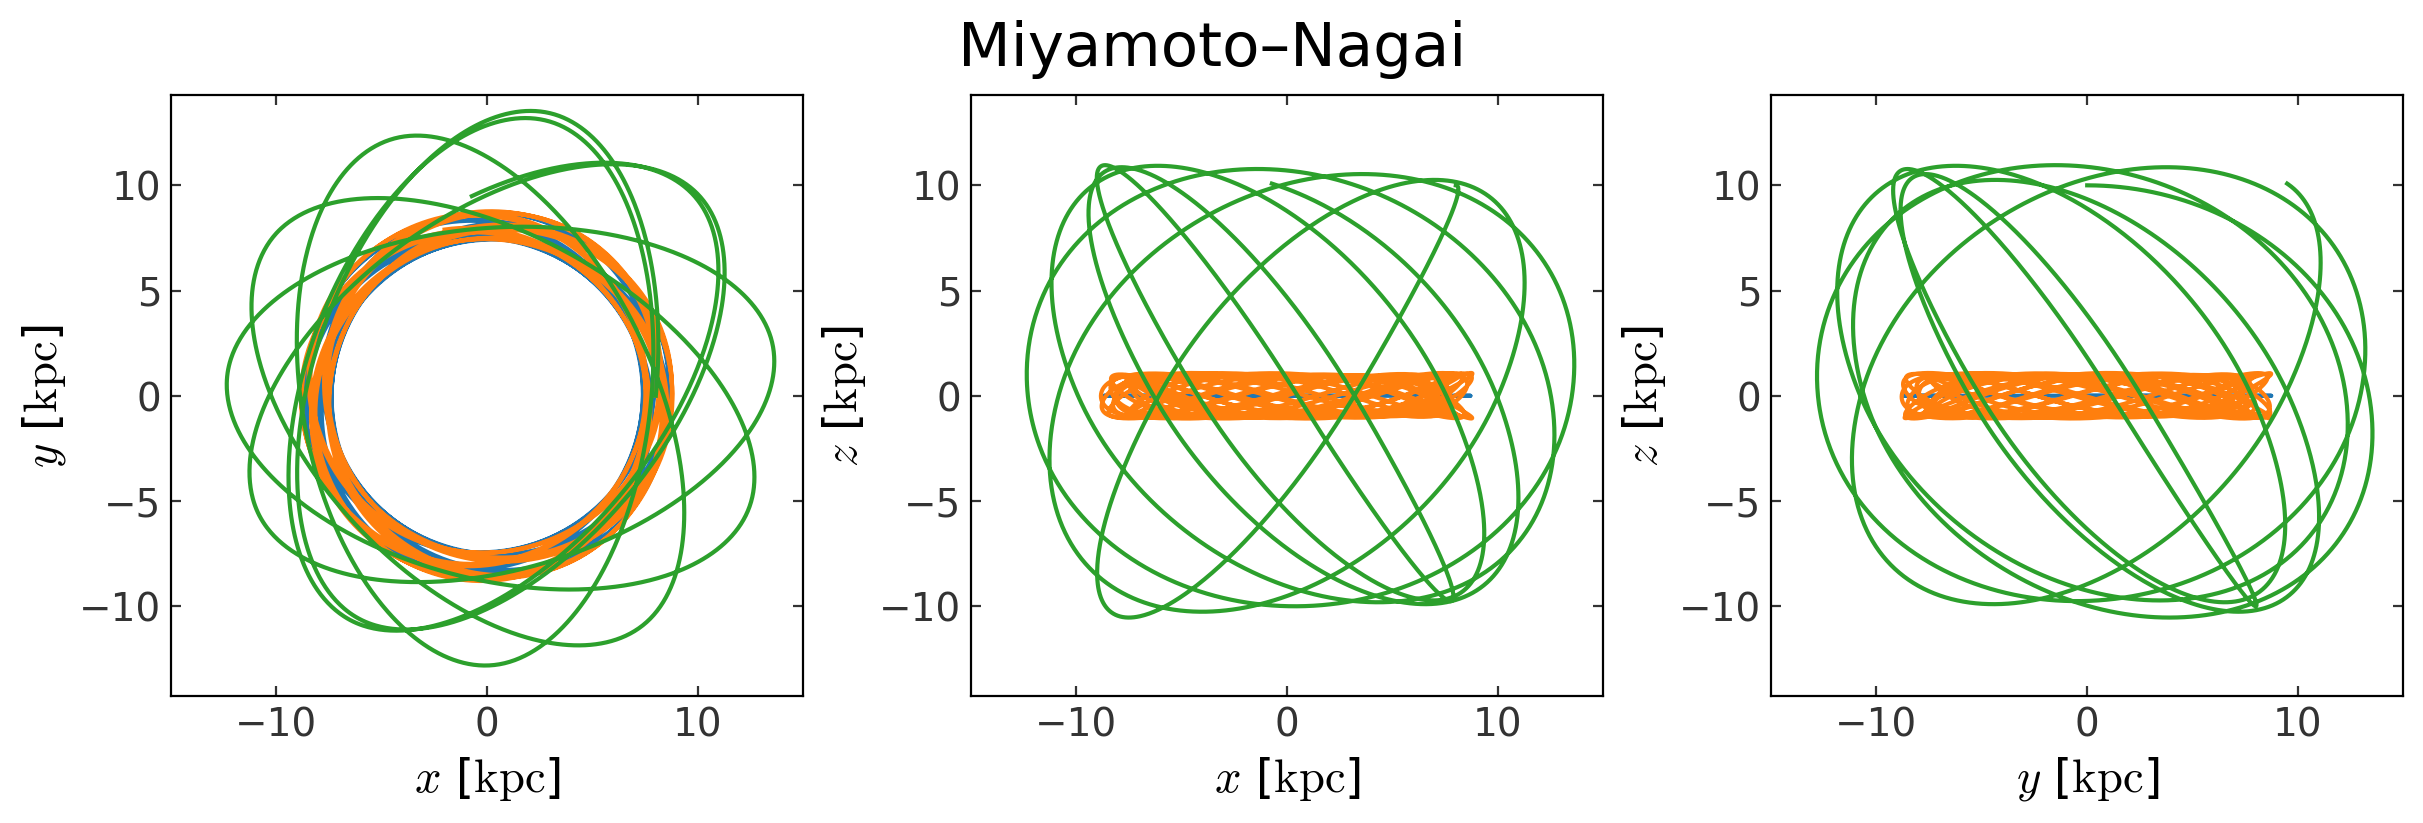

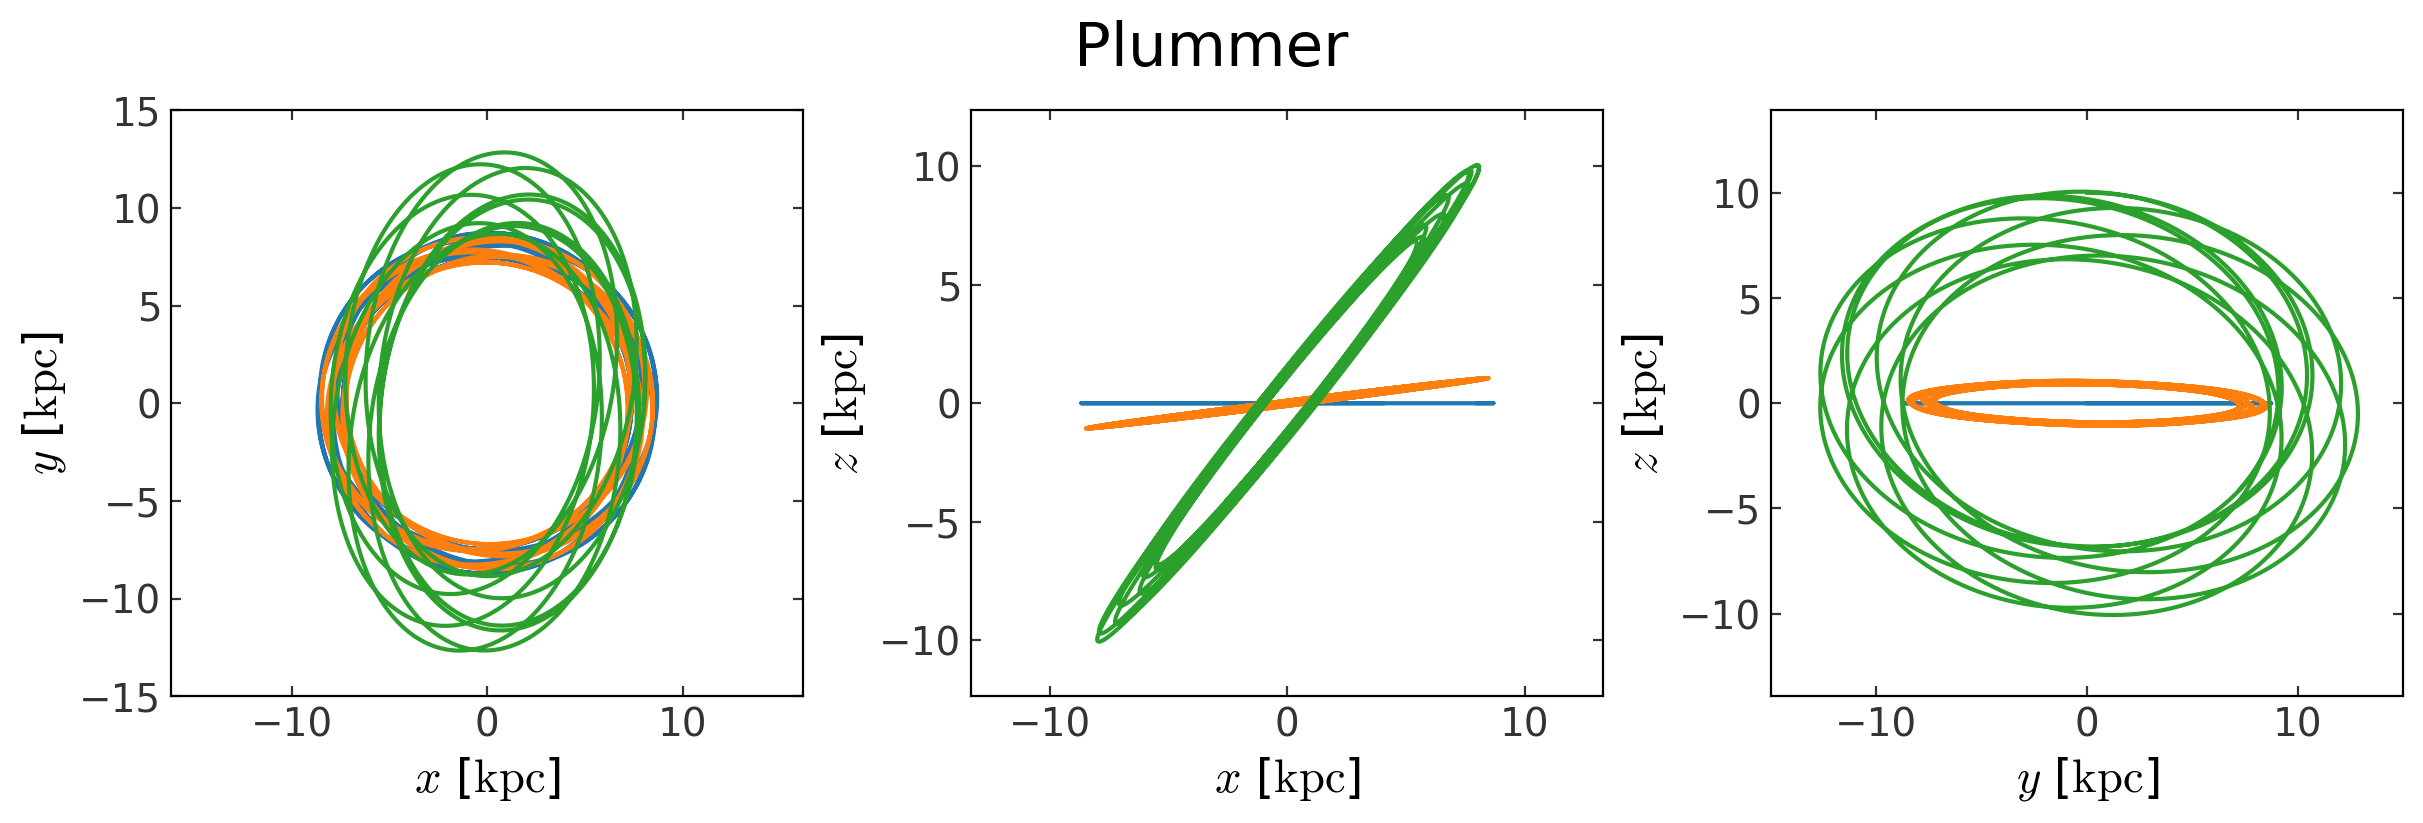

In [55]:
for orbits, name in zip([mn_orbits, plummer_orbits], ["Miyamoto–Nagai", "Plummer"]):
    fig = orbits.plot()
    for ax in fig.axes:
        ax.set_xlim(-15, 15)
        ax.set_ylim(-15, 15)
    fig.suptitle(name, fontsize=22)

Visually, it the orbits in the Plummer potential are planar (2D; as we expect), but in the Miyamoto–Nagai potential, the orbits seem to fill a 3D volume (except for the orbit started in the symmetry plane). In fact, in $x-y$ projections these orbits look a lot like their spherical analogs, however these have vertical deviations as well that give vertical thickness to the orbits: These orbits are called "tube" orbits because the surface they cover looks like a hollowed-out tube.

Because of the azimuthal symmetry of axisymmetric potentials, orbits in these models are sometimes also plotted in the *meridional plane*, which plots the cylindrical radius $R$ vs. $z$. We can plot cylindrical coordinates by using the `.cylindrical` attribute of `Orbit` objects, and then specify that we want to plot just $R$ (called `rho` in Gala) and $z$ by passing these in with the `components=` keyword argument:

Text(0.5, 1.0, 'Miyamoto–Nagai')

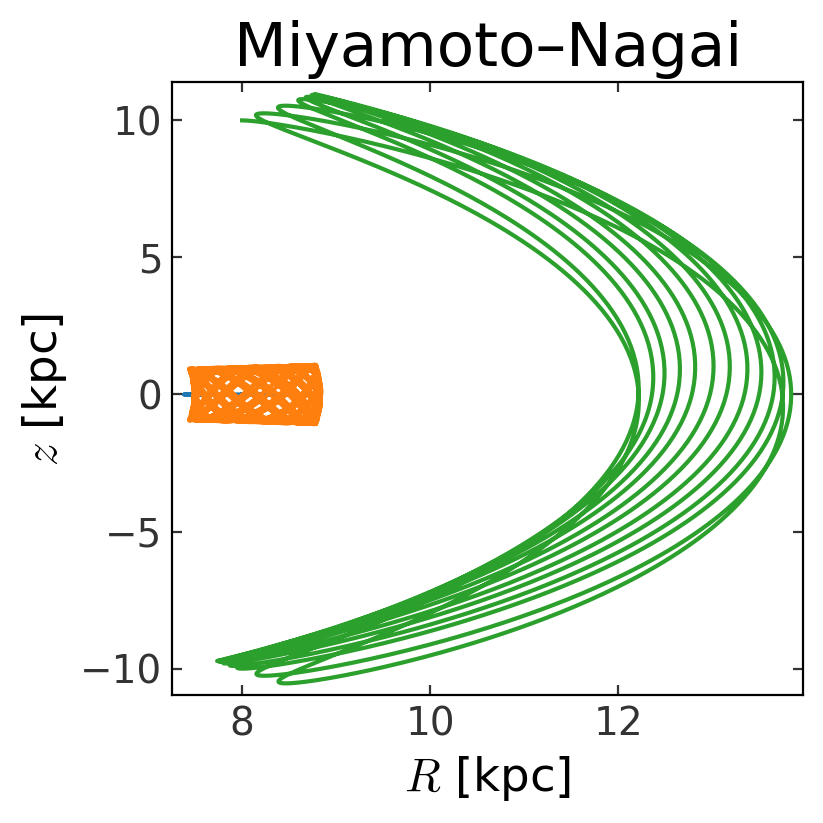

In [57]:
fig = mn_orbits.cylindrical.plot(["rho", "z"], labels=["$R$ [kpc]", "$z$ [kpc]"])
fig.axes[0].set_title("Miyamoto–Nagai", fontsize=22)

### Exercise: Why do the orbits in the Miyamoto–Nagai potential look different from the Plummer orbits?

Compute and plot the three components of the angular momentum for all orbits in both potentials. Do you see any differences? Given what we discussed about integrals of motion in the last tutorial, what do you think the connection is between the angular momentum components and the phase-space properties of the orbit?

Text(0.5, 0, 'Time')

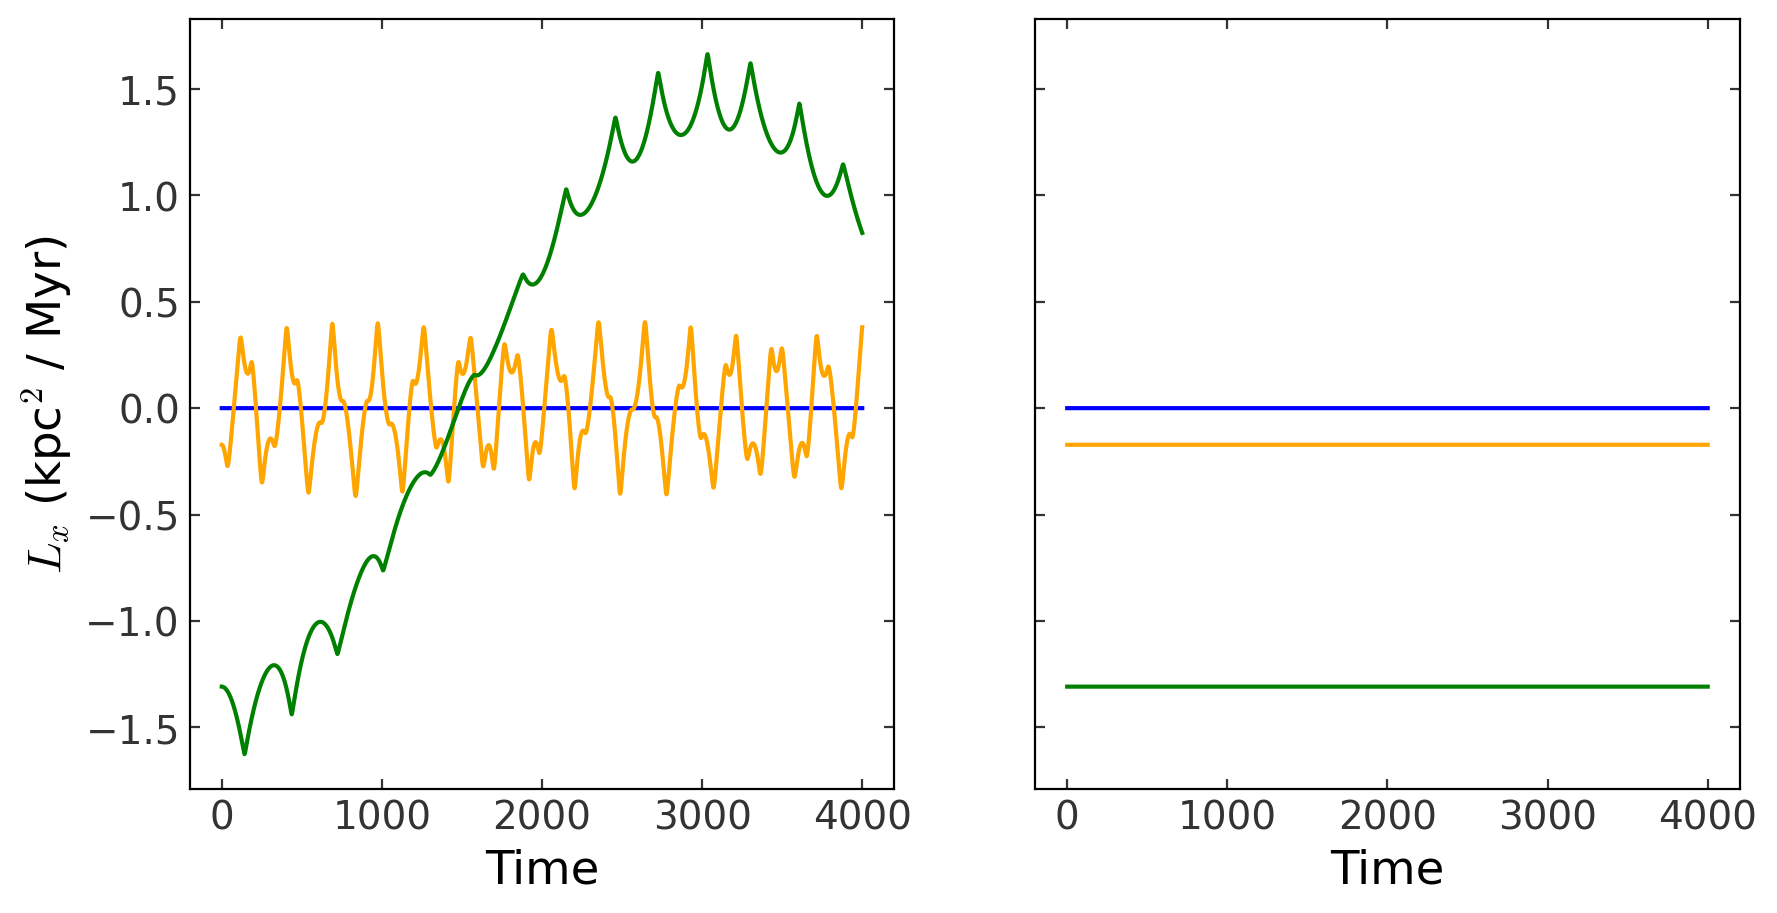

In [64]:
#plt.plot(mn_orbits.t, mn_orbits.angular_momentum())
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10,5), sharey=True)
ax1.plot(mn_orbits.t, mn_orbits.angular_momentum()[0, :, 0], c='b')
ax1.plot(mn_orbits.t, mn_orbits.angular_momentum()[0, :, 1], c = 'orange')
ax1.plot(mn_orbits.t, mn_orbits.angular_momentum()[0, :, 2], c='g')
ax1.set_ylabel(r'$L_x$ (kpc$^2$ / Myr)')
ax1.set_xlabel(r'Time')

ax2.plot(plummer_orbits.t, plummer_orbits.angular_momentum()[0, :, 0], c='b')
ax2.plot(plummer_orbits.t, plummer_orbits.angular_momentum()[0, :, 1], c='orange')
ax2.plot(plummer_orbits.t, plummer_orbits.angular_momentum()[0, :, 2], c='g')
ax2.set_xlabel(r'Time')

Text(0.5, 0, 'Time')

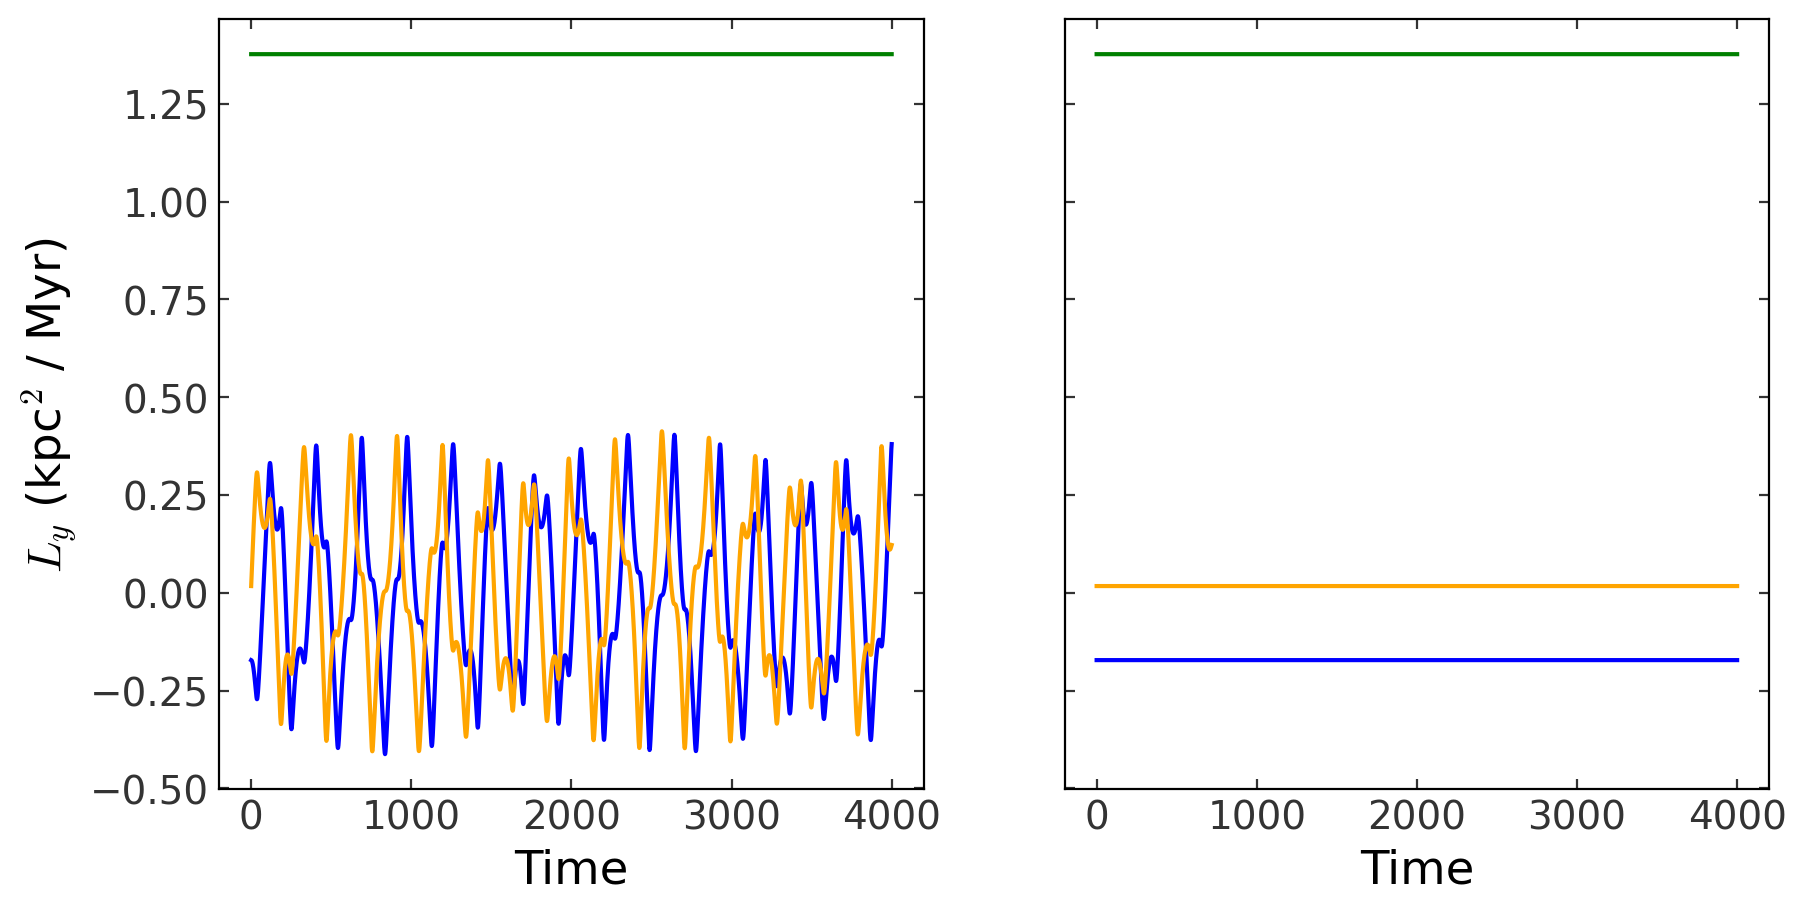

In [62]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10,5), sharey=True)
ax1.plot(mn_orbits.t, mn_orbits.angular_momentum()[0, :, 0], c='b')
ax1.plot(mn_orbits.t, mn_orbits.angular_momentum()[0, :, 1], c = 'orange')
ax1.plot(mn_orbits.t, mn_orbits.angular_momentum()[0, :, 2], c='g')
ax1.set_ylabel(r'$L_y$ (kpc$^2$ / Myr)')
ax1.set_xlabel(r'Time')

ax2.plot(plummer_orbits.t, plummer_orbits.angular_momentum()[0, :, 0], c='b')
ax2.plot(plummer_orbits.t, plummer_orbits.angular_momentum()[0, :, 1], c='orange')
ax2.plot(plummer_orbits.t, plummer_orbits.angular_momentum()[0, :, 2], c='g')
ax2.set_xlabel(r'Time')

Text(0.5, 0, 'Time')

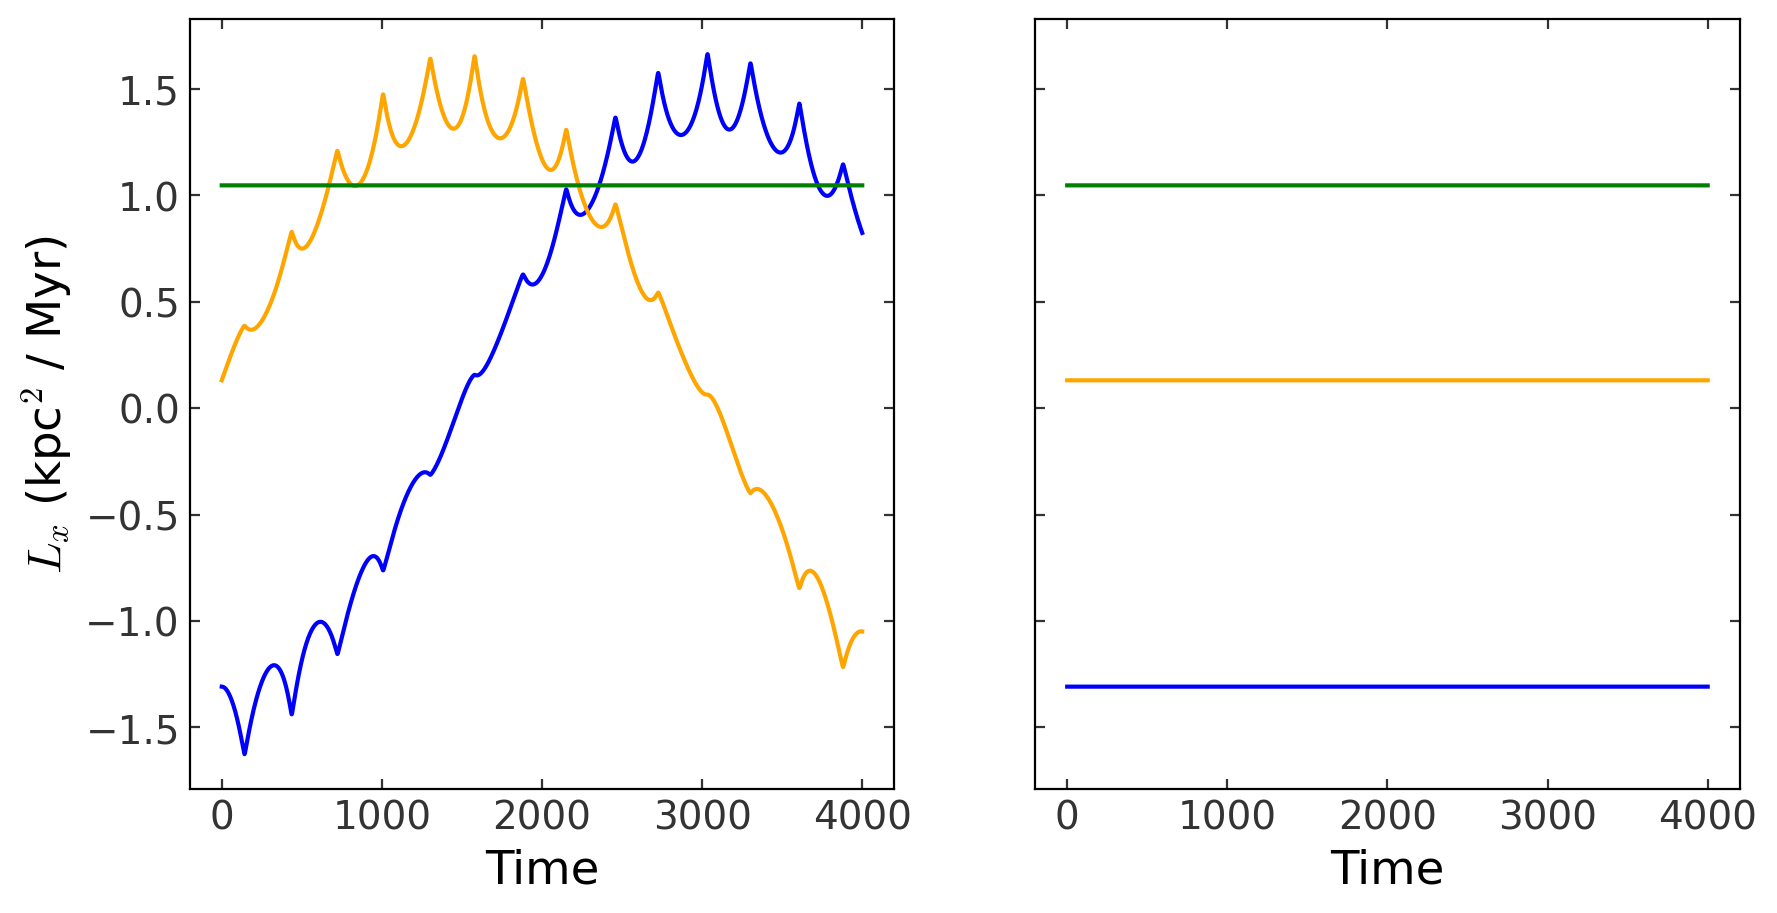

In [61]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10,5), sharey=True)
ax1.plot(mn_orbits.t, mn_orbits.angular_momentum()[0, :, 2], c='b')
ax1.plot(mn_orbits.t, mn_orbits.angular_momentum()[1, :, 2], c = 'orange')
ax1.plot(mn_orbits.t, mn_orbits.angular_momentum()[2, :, 2], c='g')
ax1.set_ylabel(r'$L_x$ (kpc$^2$ / Myr)')
ax1.set_xlabel(r'Time')

ax2.plot(plummer_orbits.t, plummer_orbits.angular_momentum()[0, :, 2], c='b')
ax2.plot(plummer_orbits.t, plummer_orbits.angular_momentum()[1, :, 2], c='orange')
ax2.plot(plummer_orbits.t, plummer_orbits.angular_momentum()[2, :, 2], c='g')
ax2.set_xlabel(r'Time')

In [36]:
mn_orbits.angular_momentum()[:, :, 0]

<Quantity [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
           [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
             0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
           [ 4.25592314e+19,  4.25592314e+19,  4.25592314e+19, ...,
             4.25592314e+19,  4.25592314e+19,  4.25592314e+19]] km2 / s>

## The epicyclic approximation: Building intuition for close-to-planar, nearly-circular orbits

Because of the azimuthal symmetry of axisymmetric potentials (so $L_z$ is conserved), the full Hamiltonian for any orbit in an axisymmetric potential (in terms of cylindrical position and conjugate momentum coordinates $p_R, p_\phi, p_z$)

$$
H(R, \phi, z, p_R, p_\phi, p_z) = \frac{1}{2}(p_R^2 + \frac{p_\phi^2}{R^2} + p_z^2) + \Phi(R, \phi, z)
$$

can be reduced to a 2D Hamiltonian that governs the motion in $R$ and $z$ (noting that $p_\phi = L_z$)

$$
H(R, z, p_R, p_z; L_z) = \frac{1}{2}(p_R^2 + p_z^2) + \Phi(R, z) + \frac{L_z^2}{2\,R^2}
$$

where now $L_z$ can be thought of as a parameter that labels an orbit, not as a coordinate. Because the terms in a Hamiltonian are often grouped into "terms that depend on the momentum coordinates" and "terms that depend on the position coordinates," the dependence on $\frac{L_z^2}{2\,R^2}$ is sometimes absorbed into the expression of the potential and referred to as the *effective potential* $\Phi_{\rm eff}(R, z)$:

$$
\Phi_{\rm eff}(R, z) = \Phi(R, z) + \frac{L_z^2}{2\,R^2}
$$

The equations of motion for $R$ and $z$ are therefore

$$
\begin{align}
    \dot{p_R} &= - \frac{\partial H}{\partial R} = - \frac{\partial \Phi_{\rm eff}}{\partial R}\\
    \dot{R} &= p_R\\
    \ddot{R} &= - \frac{\partial \Phi_{\rm eff}}{\partial R}\\
\end{align}
$$

and

$$
\begin{align}
    \dot{p_z} &= - \frac{\partial H}{\partial z} = - \frac{\partial \Phi}{\partial z}\\
    \dot{z} &= p_z\\
    \ddot{z} &= - \frac{\partial \Phi}{\partial z}\\
\end{align}
$$

In general, for relevant axisymmetric potentials used in galactic dynamics, the potential expressions are complex enough that the partial derivative expressions still contain terms that mix $R$ and $z$ so that these are still coupled differential equations.

In disk galaxies, however, most stars are on orbits such that their maximum excursions in $z$, sometimes called $z_\textrm{max}$, are much smaller than the mean cylindrical radius of the orbit, i.e. $z_\textrm{max} \ll \textrm{mean}(R)$. In this limit, it is often conceptually useful (and sometimes quantitatively reasonable) to treat the motion as if it were decoupled in the radial $R$ and vertical $z$ dimensions. In reality, the motion *is* coupled for any non-planar orbit, as we saw with the equations of motion above. We can also see this geometrically using the numerical orbits we computed above: A truly uncoupled, non-resonant orbit would fill a rectangular area in positional coordinates, whereas instead orbits in the meridional plane have a slope to their upper and lower $z$, and have curvature at maximum and minimum $R$. For example, for the non-planar, intermediate orbit we computed above, compare the area filled by this orbit to the rectangular frame of the meridional plane plot:

In [ ]:
fig = mn_orbits[:, 1].cylindrical.plot(["rho", "z"], labels=["$R$", "$z$"])

However, as an approximation to gain intuition, we can make the simplifying assumption that the motion is decoupled. Making this assumption is equivalent to assuming that the potential model is separable such that

$$
\Phi(R, z) \approx \Phi(R) + \Phi(z) \quad .
$$

With the assumption of decoupled motion, and from observing that the orbital trajectory in the meridional plane oscillates in both radius $R$ and height $z$, we can use the effective potential to find the central points in each coordinate about which the orbit oscillates. We do this by taking the derivative of the effective potential and setting it equal to zero. For the vertical direction, this is easy: We assume that any potential is symmetric about $z=0$ (a condition for it to be axisymmetric), and so

$$
0 = \frac{\partial \Phi(z)}{\partial z}
$$

must occur anywhere $z=0$.

For radius,

$$
\begin{align}
0 &= \frac{\partial \Phi_\textrm{eff}}{\partial R} \\
\frac{\partial \Phi(R)}{\partial R} &= \frac{L_z^2}{R^3}
\end{align}
$$

By convention, the radius at which this expression is valid is called the *guiding-center radius*, $R_g$:

$$
\left.\frac{\partial \Phi(R)}{\partial R}\right|_{R_g} = \frac{L_z^2}{R_g^3}
$$

The guiding center radius is an important conceptual quantity: The "guiding center" is an implicit component of the orbit that revolves around the center of the potential on a circular orbit with a constant frequency. Therefore, given our approximations so far, the only reason an orbit in an axisymmetric potential appears non-circular is because a given orbit may make radial $R$ and vertical $z$ oscillations away from the (circular, planar) guiding-center orbit.

### Exercise: Estimate the guiding center radius for an orbit in the Miyamoto–Nagai potential

Estimate the guiding center radius of a planar orbit in the MN potential (the `mn_disk` we defined above) with the initial conditions:

$$
(x,y,z) = (8.5, 0, 0.02)~\textrm{kpc}\\
(v_x,v_y,v_z) = (0, 168, 0)~\textrm{km}~\textrm{s}^{-1}\\
$$

Hint: you might find the root finder `scipy.optimize.root` useful!

Compute an orbit from these initial conditions, plot it in the meridional plane, and draw a vertical line on the plot at the location of the guiding center radius.

In [ ]:
from scipy.optimize import root

---

For the orbit you computed in the exercise above, we can get a better understanding of the geometry of epicyclic motion by plotting the orbit in a coordinate frame that rotates with the azimuthal frequency of the guiding center orbit. This frame rotates with a constant angular speed around the $z$ axis with a frequency (from dimensional analysis):

$$
\Omega_{\phi}^* = \frac{L_z}{R_g^2}
$$

With Gala, we can define a rotating reference frame using the `ConstantRotatingFrame()` frame class:

In [ ]:
guiding_center_Omega_phi = trial_Lz / trial_Rg ** 2
guiding_center_frame = gp.ConstantRotatingFrame(
    [0, 0, 1] * guiding_center_Omega_phi, units=galactic
)

We can then transform from the default, static frame to the rotating frame using the `Orbit.to_frame()` method:

In [ ]:
guiding_center_orbit = trial_orbit.to_frame(guiding_center_frame)
guiding_center_orbit

The returned object is still an `Orbit` instance, so we can plot its trajectory in the x-y plane using `.plot()` as we have done above:

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

guiding_center_orbit.plot(["x", "y"], auto_aspect=False, axes=ax)
ax.scatter(trial_Rg.value, 0, color="tab:red")

ax.set_xlim(7, 10)
ax.set_ylim(-1.5, 1.5)

In the figure above, the red dot shows the location of the guiding center, and the black smeared-out ellipse is the orbit: This is the radial epicycle! The fact that it does not close on itself (to form a perfect ellipse) is because our assumptions are approximate: the orbit also oscillates in $z$.

For even less eccentric orbits, a crude way of approximating an epicycle orbit is to combine two circular orbits: one orbit around the origin of the coordinate system (i.e. the guiding center), and the other around the guiding radius

$$
Z(t) = e^{i\,\Omega_\phi t} \, \times \, A_R\,e^{-i\,\Omega_R t}\\
x(t) = \textrm{Re}(Z)\\
y(t) = \textrm{Im}(Z)
$$

where the minus sign is because the epicycle rotates in the opposite sense, as we learned in the lectures, and $A_R$ is the amplitude of the radial epicycle (which is related to the eccentricity).

Here is an interactive plot that lets us vary the R amplitude and the ratio of $\Omega_\phi/\Omega_R$. If you recall the previous tutorial, there are two limiting cases for the frequency ratio: When $\Omega_\phi=\Omega_R$ we get a Keplerian orbit, and when $\Omega_\phi = \frac{1}{2}\Omega_R$ we get an elliptical orbit centered on the origin. Try playing with the parameter values (using the sliders under the plot below). Can you find any resonant orbits? What resonances do they correspond to?

In [ ]:
from ipywidgets import interact, widgets
from IPython.display import display

t = np.arange(0, 32, 1e-2)
Omega_phi = 2 * np.pi

fig, ax = plt.subplots(figsize=(6, 6))

(l,) = ax.plot([], [], marker="")

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")


def plot_func(Omega_phi_over_Omega_R, amp_R):
    Omega_R = Omega_phi / Omega_phi_over_Omega_R
    zz = amp_R * np.exp(-1j * Omega_R * t) + 1
    zz = zz * np.exp(1j * Omega_phi * t)

    l.set_data(zz.real, zz.imag)

    fig.canvas.draw()
    display(fig)


plt.close()

In [ ]:
omega_slider = widgets.FloatSlider(min=0.5, max=1.0, step=0.02, value=1.74)
amp_R_slider = widgets.FloatSlider(min=0, max=1, step=0.1, value=0.3)

interact(plot_func, Omega_phi_over_Omega_R=omega_slider, amp_R=amp_R_slider);

### One more frequency: azimuthal, radial, and vertical frequencies for orbits in axisymmetric models

From the previous tutorial and the previous section here, you should now be familiar with the azimuthal and radial frequencies, $\Omega_\phi, \Omega_R$. Generic orbits in axisymmetric potentials also have a third frequency: The $z$ or *vertical* frequency $\Omega_z$. Under the epicycle approximation, and with an assumed separable (in $R$, $z$) Hamiltonian, the equations of motion for $R$ and $z$ of an object are:

$$
\ddot{R} = -\frac{\partial \Phi_\textrm{eff}}{\partial R}\\
\ddot{z} = -\frac{\partial \Phi_\textrm{eff}}{\partial z}
$$

As noted previously, generically we have to solve these expressions numerically. However, to gain some intuition about the expected orbital properties, like the radial and vertical frequencies, it is useful to make one more approximation related to the epicycle assumption. If we are dealing with near-circular and near-coplanar orbits, we can get an expression for the effective potential close to an orbit's guiding center position $(R, z) \sim (R_g, 0)$ by Taylor expanding the effective potential: This will allow us to solve the orbital equations analytically.

Expanding the effective potential $\Phi_\textrm{eff}$ around the guiding center, we get:

$$
\Phi_{\textrm{eff}}(R, z) \approx \Phi_{\textrm{eff}}(R_g, 0) + 
    \frac{1}{2}\left.\frac{\partial^2\Phi_\textrm{eff}}{\partial R^2}\right|_{(R_g, 0)} \, (R-R_g)^2 +
    \frac{1}{2}\left.\frac{\partial^2\Phi_\textrm{eff}}{\partial z^2}\right|_{(R_g, 0)} \, z^2 +
    \mathcal{O}((R-R_g)\,z^2)
$$

Note that in this Taylor series approximation, the potential is separable up to mixed terms (like $(R-R_g)\,z^2$)! With this approximation, the equations of motion are (introducing the variable $X = R-R_g$ for convenience)

$$
\ddot{X} = - \left.\frac{\partial^2\Phi_\textrm{eff}}{\partial R^2}\right|_{(R_g, 0)} \, X\\
\ddot{z} = - \left.\frac{\partial^2\Phi}{\partial z^2}\right|_{(R_g, 0)} \, z
$$

which you may recognize as equations for two independent simple harmonic oscillators: One in radius, that oscillates around the guiding center, and one in vertical position that oscillates around the midplane of the potential. From these expressions, we can read off the expected frequencies of oscillation (for orbits started at the midplane, at the guiding center):

$$
\Omega_R^2 = \left.\frac{\partial^2\Phi_\textrm{eff}}{\partial R^2}\right|_{(R_g, 0)}\\
\Omega_z^2 = \left.\frac{\partial^2\Phi}{\partial z^2}\right|_{(R_g, 0)}
$$

### Exercise: Estimate (analytically) the radial, vertical, and azimuthal frequencies for an orbit at the Solar radius

The Sun is approximately at a radius of $R_\odot \approx 8.1~\textrm{kpc}$ in the Milky Way's disk. This region of the disk is still dominated (in mass) by the gravitational potential of the stars and gas, so we can neglect the dark matter halo for first approximation. 

Assuming $R_g = R_\odot$, estimate the azimuthal frequency of a circular orbit at the Solar circle using the `mn_disk` potential we defined above.

Recall that the expression for the effective potential for a Miyamoto–Nagai disk is:

$$
\Phi_\textrm{eff}(R, z) = - \frac{G \, M}{\sqrt{R^2 + (a + \sqrt{b^2 + z^2})^2}} + \frac{L_z^2}{2\,R^2}
$$

Estimate the radial and vertical frequencies for an orbit near the solar circle. How do the frequency and period values compare (radial to azimuthal to vertical)?

*Hint: you either want to take second derivatives of the expression above and evaluate this manually, or you can use the `.hessian()` method on any Gala potential object (but note that this computes the Cartesian 2nd derivative matrix at a specified position)*

## Other Axisymmetric and Flattened Potential Models

We have so far worked a lot with the Miyamoto–Nagai potential model, however like with spherical potential models, there are many options for potential–density pairs for flattened, axisymmetric potential models. In fact, as hinted at above, we can take any spherical potential model, replace the radius value with an ellipsoidal radius, and this gets us a flattened potential. However, it is worth noting that doing this for a spherical potential–density pair does not always lead to an analytic potential–density pair in axisymmetric coordinates. 

One other example of a flattened potential that can be related to a density distribution is the flattened logarithmic potential:

$$
\Phi_L(R, z) = \frac{1}{2} v_0^2 \ln\left( R^2 + \frac{z^2}{q^2} + r_c^2 \right)\\
\rho_L(R, z) = \frac{v_0^2}{4\pi \, G \, q^2} \, \frac{(2\,q^2 +1)\,r_c^2 + R^2 + (2 - \frac{1}{q^2})\,z^2}{(R^2 + \frac{z^2}{q^2} + r_c^2)^2}
$$

where $q$ sets the amount of flattening (when $q = 1$, this is a spherical model).

Like the spherical logarithmic potential, this flattened model has the feature that when $R \gg r_c$, the circular velocity curve is close to constant with a value $v_c \approx v_0$, and is therefore useful for constructing simple mass models for computing orbits in the combined stars + dark matter potential of a Galaxy. However, as this model was defined by turning a spherical logarithmic *potential* model into a flattened potential model, the density does not have to be physically meaningful at all positions for all parameter values.

### Exercise: Are there values for the parameters (q, r_c) that lead to unphysical density values?

What values of the parameters?

## Integrals of motion for axisymmetric orbits: Connection to action-angle coordinates

We have talked a lot about approximating orbits in axisymmetric potentials because most stars in the Milky Way are on orbits that can be described using the terminology and quantities we have discussed so far. We have focused a lot on the different frequencies that an orbit can have in different cylindrical coordinates, assuming that the motion is separable. However another important aspect of the geometry of axisymmetric orbits is the *amplitude* of oscillation in the different coordinates. 

As we discussed early on in this tutorial, in axisymmetric models, a generic orbit has three integrals of motion, which could be energy, $z$-component of angular momentum, and the "third integral." It turns out that any orbit also has a different set of three integrals of motion that has a closer connection to the orbital geometry we discussed: something close to the amplitude of oscillations in the radial direction, something close to the amplitude of oscillations in the vertical direction, and the $z$-component of angular momentum (which is the analog of the others for the azimuthal direction) — these are the "radial action" $J_R$, the "vertical action" $J_z$, and the "azimuthal action" $J_\phi = L_z$. I added the phrase "something close to" in the previous sentence because the actions are not exactly related to the amplitudes in $R$ and $z$: Most of the expressions and intuition-building approximations we have made above have been under the assumption that the potential is separable in these coordinates. But we also saw that this is not true in detail (there is curvature to the orbital boundaries when orbits are plotted in the meridional $R,Z$ plane). The actions are like a generalization of the conceptual / approximate arguments we made above, but which take into account the fact that the orbits are not separable in detail.

Actions are special and useful for a number of reasons. For one, they connect to the intuitions we built about orbits above: For example, orbits with larger radial action have larger oscillations in $R$, and the same for $z$. But, as mentioned briefly in the previous tutorial, they also help define a dynamically-useful coordinate system known as action-angle coordinates. In this coordinate system, any point in ordinary phase-space $(\boldsymbol{x}, \boldsymbol{v})$ can be represented instead by a location in action-angle coordinates $(\boldsymbol{\theta}, \boldsymbol{J})$, where for axisymmetric orbits the actions and angles are:

$$
\boldsymbol{J} = (J_R, J_\phi, J_z)\\
\boldsymbol{\theta} = (\theta_R, \theta_\phi, \theta_z)
$$

where $J_\phi = L_z$, and in the limit $J_R, J_z \rightarrow 0$, $\theta_\phi \rightarrow \phi$.

The actions, which are the momentum coordinates, are integrals of motion, so $\dot{\boldsymbol{J}} = 0$. The Hamiltonian equations of motion are therefore:

$$
\dot{J}_i = -\frac{\partial H}{\partial \theta_i} = 0\\
\dot{\theta}_i = \frac{\partial H}{\partial J_i}
$$

This implies that the Hamiltonian $H$ must depend only on the actions, and so the expressions $\frac{\partial H}{\partial J_i}$ must be a function only of the actions. We can therefore integrate the equations of motion for the angle variables:

$$
\dot{\theta}_i = \frac{\partial H}{\partial J_i}\\
\theta_i(t) = \frac{\partial H}{\partial J_i} \, t + \theta_{i}(0)
$$

The angle variables increase linearly with time with a constant rate set by $\frac{\partial H}{\partial J_i}$, which must have units of frequency: We therefore define the *fundamental frequencies* of an orbit to be:

$$
\Omega_i = \frac{\partial H}{\partial J_i}
$$

which, in vector form, will be $\boldsymbol{\Omega} = (\Omega_R, \Omega_\phi, \Omega_z)$!

Action-angle coordinates are conceptually and dynamically very useful, and there is a lot more to be said about them. However, a subtlety of working with these coordinates is that it is often challenging to transform from $(x, v) \rightarrow (J, \theta)$ and even more challenging to transform back $(J, \theta) \rightarrow (x, v)$. The transformation often requires either numerically integrating an orbit for a long time, or making approximations to the potential (that often are not valid for all types of orbits). We will not talk much about the different methods for numerically estimating actions and angles (unless you ask!), but we recommend checking out [Sanders et al. 2016](https://ui.adsabs.harvard.edu/abs/2016MNRAS.457.2107S/abstract) if you are interested.